#Board Game Review Classifier

Muhammad Arham

1001686912

Term Project, Data Minig, Spring 2020

In this project, we will be working with Board Game reviews dataset, we have acquired from kaggle. In this dataset we have been provided with three files. Our major concern is with the board game review file, which contains user comments and ratings for a game. Our goal is, given the board game review, we have to predict what rating out of 10 it will have.

For multi-class text classification Naive Bayes theorem has proved to be the best algorithm out there, but a lesser known fact is that a machine learning model is only as good as the data it has been trained on.

We are dealing with a massive dataset with a file size of more than 1GB. Alot of preprocessing and cleaning of data will be required before we can feed the model the data for it to train on. Since this is a textual dataset, we will be making use of regexp and many other libraries throughout this project to keep our focus on the actual problem, of building a good machine learning model.

Disclaimer: This notebook is not created on jupyter, but on Google Colab, since i kept running into memory issues in pd.read_csv, even with reading the inputs in chunks. It might take longer for the notebook to run on kaggle.

##Imports

In [42]:
import pandas as pd
import numpy as np
import string
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import naive_bayes
from sklearn import svm
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier
!pip install Unidecode

nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')

import unidecode

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Loading the Dataset

For text classification, the comment and rating columns were useful, hence only those were read from the csv file. 

*This in turn might help with minimizing running time, and in-memory storage of the Dataframe

In [0]:
path= '/content/drive/My Drive/Colab Notebooks/bgg-13m-reviews.csv'

reviews=pd.read_csv(path, usecols = ['comment','rating'],engine='python')

In [3]:
reviews.head()

,rating,comment
0,10.0,NaN
1,10.0,NaN
2,10.0,"Currently, this sits on my list as my favorite..."
3,10.0,"I know it says how many plays, but many, many ..."
4,10.0,NaN


As we can see, our dataset has almost 13M+ rows. We need to pre-process the data to refine our dataset, as much as possible, without influencing the end result.

#Preprocesing the Dataset

This is one of the key parts of our project, because a model is only as efficent as the Data set it has been trained on.

###Removing Missing rows

The Data set has many rows with NaN values, and since for our usage we cannot handle the missing values, we will simply drop them.

In [0]:
reviews = reviews.dropna()

## Cleaning the Data set

###Cleaning Comments:

To cleaning our Data set for classification, we need to take care of the following

*   HTML tags
*   URL tags
*   String containing only numbers
*   String containing punctuations
*   Empty Strings
*   Lowercase
*   Non-english words
*   Stopwords

1. HTML Tags and URL tags to websites with reviews are useless and are therefore omitted.

2. String containing only numbers, and not words cannot be used for text classification purposes and therefore are removed.

3. Strings with punctutaions when tokenized might make token out of punctutations and in cases of contractions such as "can't" and "cant" would be identified as two separate words.

4. Empty Strings can also be counted under missing values and be removed,by making them NaN and dropna().

5. Applying lowercase to all text ensures that, words like 'the' and 'The' arent identified separately.
 
6. Comments written in roman english, or in chinese or spanish are noise for a dictionary based in english, hence those words need to removed. So we can convert unicode to ascii using  unidecode, and use nltk corpus

7. Stop words are those words in natural language that have a very little meaning, such as "is", "an", "the", etc. They provide little to no unique information that can be used for classification

In [0]:
def deep_cleaner(comment):
  clean_number = re.compile(r'^(\d|-)?(\d|,)*\.?\d*$')
  clean_html = re.compile(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)')
  clean_url = re.compile(r'https?://\S+\www\.\S+')
  clean_punctuation = re.compile(r'[^\w\s]+')
  comment = clean_number.sub(r'',comment)
  comment = clean_html.sub(r'', comment)
  comment = clean_url.sub(r'', comment)
  comment = clean_punctuation.sub(r'',comment)
  comment = unidecode.unidecode(comment)
  
  return comment


reviews["comment"] = reviews["comment"].apply(lambda comment: deep_cleaner(comment))

In [0]:
reviews["comment"].replace('', np.nan, inplace=True)
#removing rows with NaN
reviews.dropna(inplace =True)

In [0]:
words = set(nltk.corpus.words.words())

def onlyEnglish(comment):
  return " ".join(w for w in nltk.wordpunct_tokenize(comment) if w.lower() in words or not w.isalpha())

reviews["comment"] = reviews["comment"].apply(lambda comment: onlyEnglish(comment))

In [0]:
stop_words = set(stopwords.words('english'))

def noStopwords(comment):
  return " ".join(w for w in nltk.wordpunct_tokenize(comment) if w not in stop_words)

reviews["comment"] = reviews["comment"].apply(lambda comment: noStopwords(comment))

### Ratings Column:

In [9]:
reviews['rating'].value_counts()

7.00000    520710
8.00000    428250
6.00000    389902
9.00000    214802
5.00000    209675
            ...  
7.15700         1
3.51000         1
8.74600         1
4.71500         1
8.29333         1
Name: rating, Length: 3404, dtype: int64

As we can see, the rating column has float values, and they also have very low frequencies, which will complicate our problem by increasing the number of classes to more than 10. 

To tackle this problem we can simply cast the whole column as an int type, and discretize them

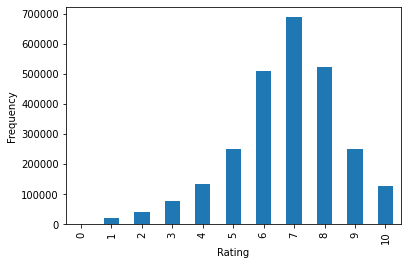

In [10]:
reviews['rating'] = reviews['rating'].astype(np.int64)

reviews['rating'].value_counts(sort=False).plot(kind = 'bar')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.show()

We can see, the data is imbalanced, and certain classes have higher frequency compareed to the others.

*Optionally, we can also remove the rating 0, since the frequency of that class, compared to others is miniscule

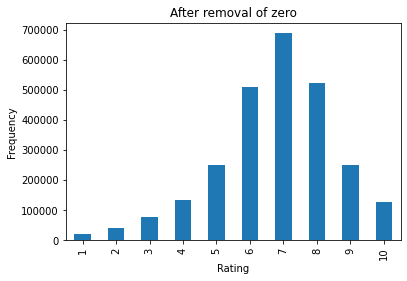

In [11]:
reviews = reviews[reviews['rating'] >= 1]

reviews['rating'].value_counts(sort=False).plot(kind = 'bar')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.title('After removal of zero')
plt.show()

### Final Data Set

In [12]:
reviews = reviews.reset_index(drop=True)
reviews.head()

,rating,comment
0,10,Currently list favorite game
1,10,I know many many many uncounted I version best
2,10,never tire game Awesome
3,10,This probably best game I ever thinking negoti...
4,10,Fantastic game Got hooked


###Sampling the Data set

Since the Data set is absolutely massive, we can take a random sample using pandas's sample function. This will make this project more manageable, and will be able to run on smaller machines.

Ive selected size of N as 100,000. This will sample N rows from the original dataset, at random

In [0]:
sample = reviews.sample(n=100000)
sample = sample.reset_index(drop=True)

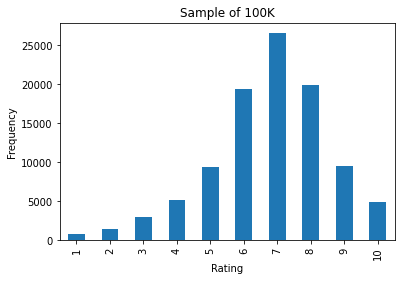

In [14]:
sample['rating'].value_counts(sort=False).plot(kind = 'bar')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.title('Sample of 100K')
plt.show()

The bar graph for the original Data set and the sample looks similar, indicating the sample is somewhat an accurate representation of the original Data set 

###Prepare Train and Test Data sets

We need to split our Data set into train and test splits to later assess its performance.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(sample['comment'], sample['rating'], test_size=0.2,random_state=np.random)

###Vectorization

We now convert our sample['comments'] into numerical feature vectors. The method of our choice is TF-IDF, which is Term Frequency-Inverse Document Frequency.

In [0]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2), 
    encoding='latin-1',
    max_features = 500000
)

vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

##Classifiers

###Naive Bayes Classifier

It is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. In simple terms, a Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature.

Our goal is multi-class text classification. A well known algorithm for text classification is Naive Bayes, which takes vector inputs from TF-IDF and predicts its class.

In [17]:
NB = naive_bayes.MultinomialNB()
NB.fit(X_train_vec,y_train)

predictions_NB = NB.predict(X_test_vec)



# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(predictions_NB,y_test )*100)

Accuracy: 27.115000000000002


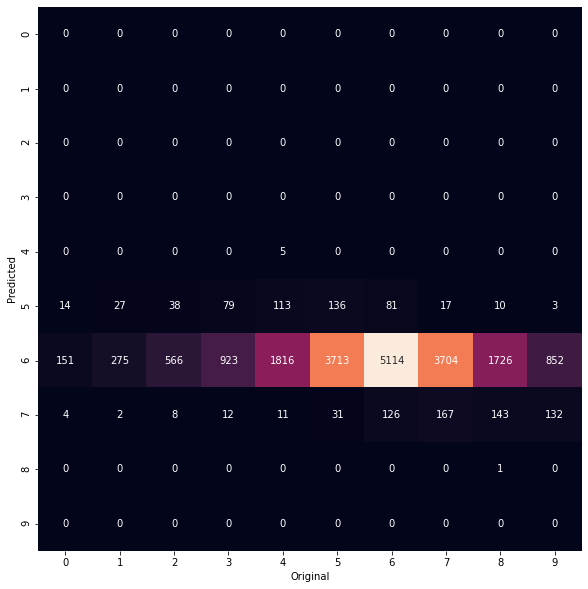

In [18]:
conf_matrix_NB = confusion_matrix(y_test, predictions_NB)
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(conf_matrix_NB.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Original')
plt.ylabel('Predicted');

In the heatmap, we can visualize that most of our results overfit to classes around 7, since the data we provided was imbalanced, and that class 7 had the highest frequency followed by 6 & 8

Unlike our initial hypothesis, Naive bayes isnt performing as expected.


###Hyper Parameter Tuning

We need to find the optimal value of alpha for our Data set.
We will use gridsearch for this purpose

In [19]:
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
model_NB = naive_bayes.MultinomialNB()
grid = GridSearchCV(cv= 5, estimator=model_NB, param_grid=dict(alpha=alphas))
grid.fit(X_train_vec, y_train)
#print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


0.28523750000000003
0.1


Best estimate of alpha, according to our grid search, that used 5 fold cross validation was: 0.1


##Linear SVM

In the SVM algorithm, we plot each data item as a point in n-dimensional space (where n is number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiates the two classes very well 

In [20]:
Linear_SVC = svm.LinearSVC()
Linear_SVC.fit(X_train_vec,y_train)

predictions_SVM = Linear_SVC.predict(X_test_vec)


print("SVM Accuracy Score -> ",metrics.accuracy_score(predictions_SVM, y_test)*100)

SVM Accuracy Score ->  27.665


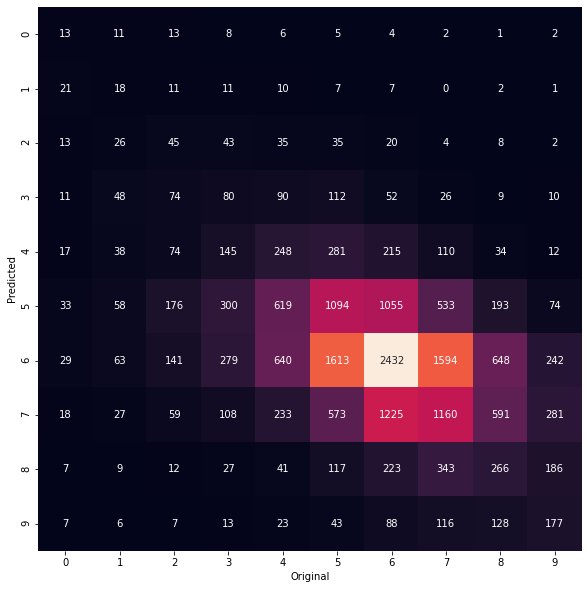

In [21]:
conf_matrix_SVM= confusion_matrix(y_test, predictions_SVM)
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(conf_matrix_SVM.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Original')
plt.ylabel('Predicted');

###Hyper Parameter Tuning

We need to find optimal values of C

1. C is the penalty parameter which represents our missclassification, and tells us how much error is bearable. This is how we can control the trade-off between decision boundary and misclassification term.

*This was taking a considerable amount of time. 
We have used C = 1, for our purposes

In [0]:
#from sklearn.svm import SVC  
#params = {'C': [0.1,1, 10, 100]}
#model_SVM = svm.LinearSVC()
#grid = GridSearchCV(estimator = model_SVM, param_grid=params, cv= 5 )
#grid.fit(X_train_vec, y_train)
#print(grid)
# summarize the results of the grid search
#print(grid.best_score_)
#print(grid.best_estimator_)

## Handling Imbalanced Classes

As we can see from the results of Naive Bayes, the classifier's predictions for lower ratings are poor. Imbalanced Data set can be attributed for this result, as their were lesser number of comments with lower ratings.

We can perform undersampling on this data, as we have a huge Data set to overcome this problem of imbalanced Data set, and try using the classifiers on that data.

In [23]:
reviews['rating'].value_counts()

7     688489
8     522667
6     508350
5     249192
9     249127
4     132242
10    126329
3      75795
2      39925
1      21113
Name: rating, dtype: int64

*We can have approximately 10,000 samples from each class, with undersampling, as the class with lowest count '1' has 20K+ records.
This will result in a Data set of 100K+ records

In [24]:
reviews_1 = reviews[reviews['rating'] == 1]
reviews_2 = reviews[reviews['rating'] == 2]
reviews_3 = reviews[reviews['rating'] == 3]
reviews_4 = reviews[reviews['rating'] == 4]
reviews_5 = reviews[reviews['rating'] == 5]
reviews_6 = reviews[reviews['rating'] == 6]
reviews_7 = reviews[reviews['rating'] == 7]
reviews_8 = reviews[reviews['rating'] == 8]
reviews_9 = reviews[reviews['rating'] == 9]
reviews_10 = reviews[reviews['rating'] == 10]

review_1_downsampled = resample(reviews_1, 
                                 replace=False,    # sample without replacement
                                 n_samples=10000,     # to match minority class
                                 random_state=np.random) # reproducible result
review_2_downsampled = resample(reviews_2, 
                                 replace=False,    # sample without replacement
                                 n_samples=10000,     # to match minority class
                                 random_state=np.random) # reproducible results
review_3_downsampled = resample(reviews_3, 
                                 replace=False,    # sample without replacement
                                 n_samples=10000,     # to match minority class
                                 random_state=np.random) # reproducible results
review_4_downsampled = resample(reviews_4, 
                                 replace=False,    # sample without replacement
                                 n_samples=10000,     # to match minority class
                                 random_state=np.random) # reproducible results
review_5_downsampled = resample(reviews_5, 
                                 replace=False,    # sample without replacement
                                 n_samples=10000,     # to match minority class
                                 random_state=np.random) # reproducible results
review_6_downsampled = resample(reviews_6, 
                                 replace=False,    # sample without replacement
                                 n_samples=10000,     # to match minority class
                                 random_state=np.random) # reproducible results
review_7_downsampled = resample(reviews_7, 
                                 replace=False,    # sample without replacement
                                 n_samples=10000,     # to match minority class
                                 random_state=np.random) # reproducible results
review_8_downsampled = resample(reviews_8, 
                                 replace=False,    # sample without replacement
                                 n_samples=10000,     # to match minority class
                                 random_state=np.random) # reproducible results
review_9_downsampled = resample(reviews_9, 
                                 replace=False,    # sample without replacement
                                 n_samples=10000,     # to match minority class
                                 random_state=np.random) # reproducible results
review_10_downsampled = resample(reviews_10, 
                                 replace=False,    # sample without replacement
                                 n_samples=10000,     # to match minority class
                                 random_state=np.random) # reproducible results

reviews_downsampled = pd.concat([review_1_downsampled,review_2_downsampled,review_3_downsampled,review_4_downsampled,review_5_downsampled,review_6_downsampled,review_7_downsampled,review_8_downsampled,review_9_downsampled,review_10_downsampled])
reviews_downsampled.shape

(100000, 2)

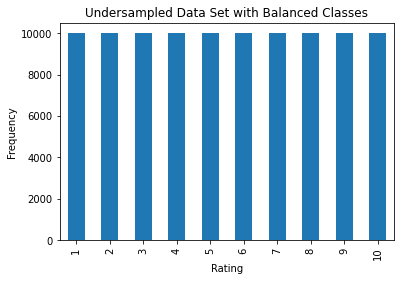

In [25]:
reviews_downsampled['rating'].value_counts(sort=False).plot(kind = 'bar')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.title('Undersampled Data Set with Balanced Classes')
plt.show()

### Balanced Test & Train Data sets

In [0]:
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(reviews_downsampled['comment'], reviews_downsampled['rating'], test_size=0.2,random_state=np.random)

### Vectorization

In [0]:
vectorizer.fit(X_train_bal)
X_train_bal_vec = vectorizer.transform(X_train_bal)
X_test_bal_vec = vectorizer.transform(X_test_bal)

### Naive Bayes on Balanced Data Set

In [28]:
NB_Bal = naive_bayes.MultinomialNB()
NB_Bal.fit(X_train_bal_vec,y_train_bal)

predictions_NB_Bal = NB_Bal.predict(X_test_bal_vec)



# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(predictions_NB_Bal,y_test_bal )*100)

Accuracy: 26.040000000000003


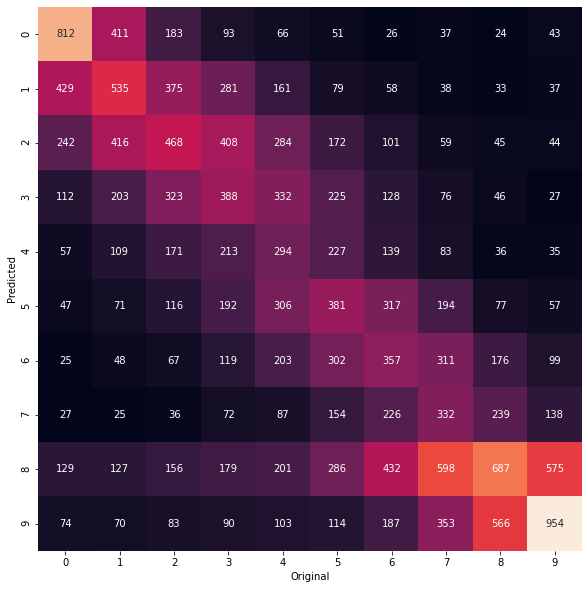

In [29]:
conf_matrix_NB_Bal = confusion_matrix(y_test_bal, predictions_NB_Bal)
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(conf_matrix_NB_Bal.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Original')
plt.ylabel('Predicted');

*Here we can see, our classifier has dropped in accuracy, but is now able to classify lower ratings too

### Hyper Parameter Tuning

In [30]:
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
model_NB_Bal = naive_bayes.MultinomialNB()
grid = GridSearchCV(cv= 5, estimator=model_NB_Bal, param_grid=dict(alpha=alphas))
grid.fit(X_train_bal_vec, y_train_bal)
#print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


0.2591
1.0


In [31]:
X_test_vec.shape, X_test_bal_vec.shape

((20000, 500000), (20000, 500000))

Now that our Naive Bayes classifier can classify lower ratings, lets look at how it performs on the original unbalanced Data set

Accuracy: 10.334999999999999


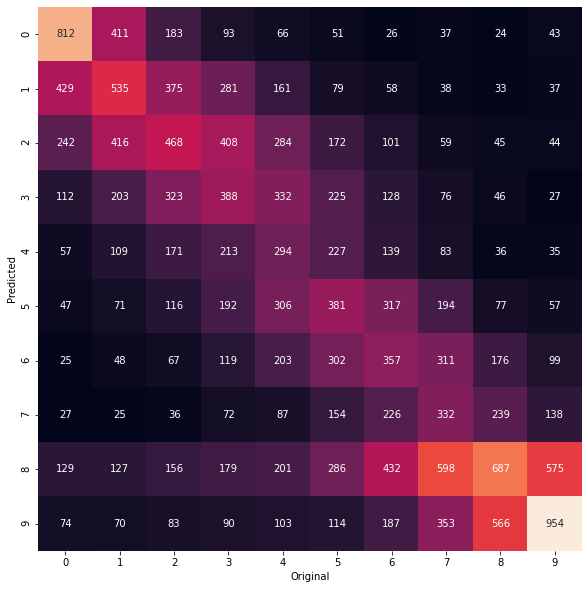

In [32]:
predictions_NB_Bal_2 = NB_Bal.predict(X_test_vec)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(predictions_NB_Bal_2,y_test )*100)

conf_matrix_NB_Bal_2 = confusion_matrix(y_test, predictions_NB_Bal_2)
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(conf_matrix_NB_Bal.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Original')
plt.ylabel('Predicted');

Looks like our balanced Naive bayes performed poorly on the unbalanced Dataset, but was able to capture the lower ratings on the Data set

###Linear SVM on Balanced Data set

In [33]:
Linear_SVC_Bal = svm.LinearSVC()
Linear_SVC_Bal.fit(X_train_bal_vec,y_train_bal)

predictions_SVM_bal = Linear_SVC_Bal.predict(X_test_bal_vec)


print("SVM Accuracy Score -> ",metrics.accuracy_score(predictions_SVM_bal, y_test_bal)*100)

SVM Accuracy Score ->  24.349999999999998


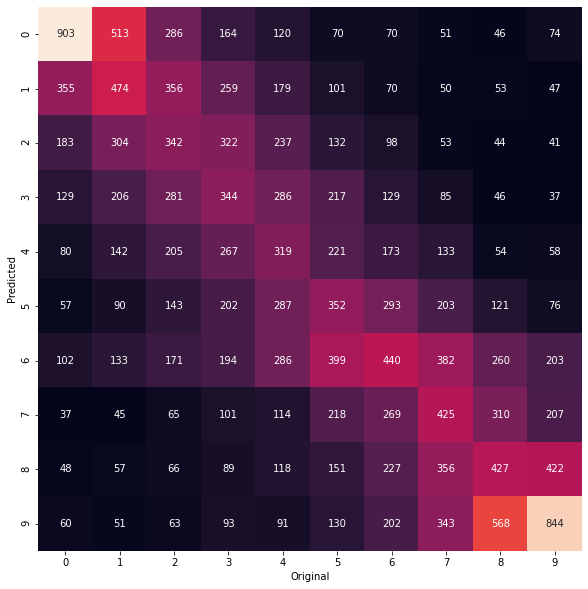

In [34]:
conf_matrix_SVM_bal= confusion_matrix(y_test_bal, predictions_SVM_bal)
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(conf_matrix_SVM_bal.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Original')
plt.ylabel('Predicted');

Now that our Linear SVC classifier can classify lower ratings, lets look at how it performs on the original unbalanced Data set

SVM Accuracy Score ->  12.29


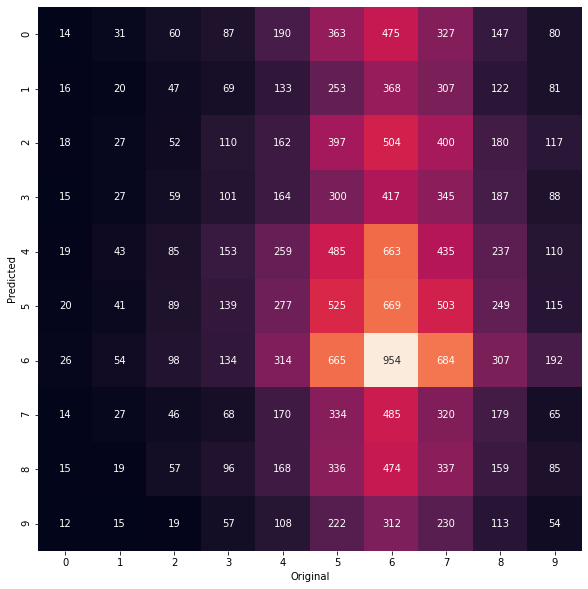

In [37]:
predictions_SVM_Bal_2 = Linear_SVC_Bal.predict(X_test_vec)


print("SVM Accuracy Score -> ",metrics.accuracy_score(predictions_SVM_bal_2, y_test)*100)

conf_matrix_SVM_Bal_2 = confusion_matrix(y_test, predictions_SVM_Bal_2)
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(conf_matrix_SVM_Bal_2.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Original')
plt.ylabel('Predicted');

Looks like our balanced Linear SVM performed poorly on the unbalanced Dataset, but was able to capture the lower ratings on the Data set. Accuracy dropped more than 50%

## Ensemble Classifiers

Considering the performances of Naive Bayes and Linear SVM on our balanced and unbalanced Data set, we will now try and build a classifier, based on Balanced and Unbalanced Linear SVM

Ensemble SVM Accuracy Score ->  27.665


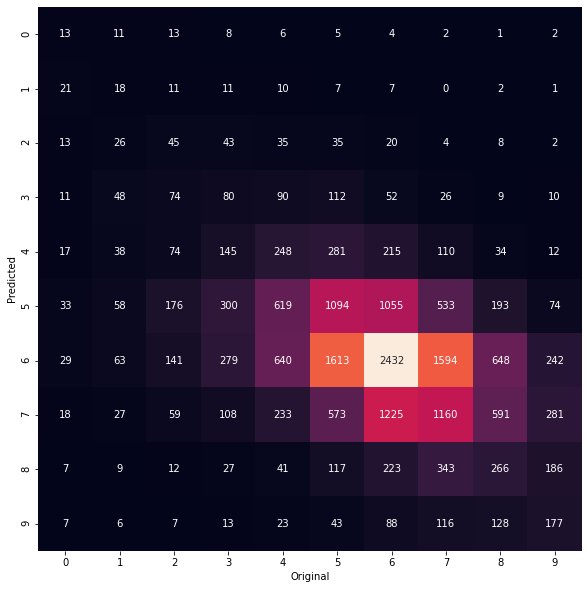

In [47]:
estimators=[('SVC_Bal', Linear_SVC_Bal), ('SVC', Linear_SVC)]

ensemble = VotingClassifier(estimators, voting='hard')

#fit model to training data
ensemble.fit(X_train_vec, y_train)

predictions_Ensemble = ensemble.predict(X_test_vec)

#test our model on the test data
print("Ensemble SVM Accuracy Score -> ",ensemble.score(X_test_vec, y_test)*100)

conf_matrix_Ensemble = confusion_matrix(y_test, predictions_Ensemble)
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(conf_matrix_Ensemble.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Original')
plt.ylabel('Predicted');

The ensemble voting classifer with hard voting shows an accuracy of 27% approximately

### Relaxation of Accuracy Measure

Uptill now, only count a rating to be a correct prediction, if its equal to the original rating. 
If we relax this measure of accuracy, by +/-1 point, we might see an increment in accuracy.

The sentiment of a rating from a 7 to an 8 isnot that drastic, that it might change the meaning behind the rating.

In [0]:
def relaxedAccuracy(pred,target):
  correct = 0
  for i in range(len(target)):
    if (target[i]==pred[i] or target[i]==(pred[i]+1) or target[i]==(pred[i]-1)):
      correct+=1

  return (correct/len(target))*100

In [78]:
accuracy = relaxedAccuracy(predictions_Ensemble,y_test.values)
print("Relaxes Ensemble SVC accuracy ->",accuracy)
accuracy = relaxedAccuracy(predictions_NB,y_test.values)
print("Relaxed NB accuracy ->",accuracy)
accuracy = relaxedAccuracy(predictions_SVM,y_test.values)
print("Relaxed SVM accuracy ->",accuracy)

Relaxes Ensemble SVC accuracy -> 67.945
Relaxed NB accuracy -> 66.515
Relaxed SVM accuracy -> 67.945


After applying the relaxation function, our correct predictions more than doubled.

This proves that our relaxed accuracy idea was a success.

##Challenges:



1.   The sheer volume of Data set, was a major hurdle. Reading the dataset on my personal computer wasnt even possible. I had to use google colab to complete all of this work. Even then i had to sample the data, instead of using the whole data as the time it would take to proces the data was insanely long
2.   Preprocessing the data was also cumbersome, since this was a text classification problem, it was critical the data was as clean as possible. With the help of regex and python's apply function, the data was cleaned, but tasks such as lemmatizing and stemming were too tedious to perform
3.   The imbalanced dataset was a problem on its own, and training pretrained classifiers on it dropped accuracies to single digits. I was able to undersample a dataset of relatively large size and use ensemble method to get a ensemble classifier which performed perfectly
4.   The low accuracy score of the coveted Naive Bayes algorithm was a shock, which opened my eyes to the fact that data can make or break an algorithm, and SVM performed better than our Naive Bayes
5.   Deploying the model on live website was a challenge on its own. 1GB dataset was way beyond the limitations of free hosting websites.



##Conclusion:

Ensemble SVM, which contained had Linear SVMs from both balanced and imbalanced dataset, had the highest accuracy in our study. It manages the class imbalance, while maintaining somewhat satisfactory prediction ratings.

## References

https://stackoverflow.com/questions/50444346/fast-punctuation-removal-with-pandas

https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string

https://stackoverflow.com/questions/37335598/how-to-get-the-length-of-a-cell-value-in-pandas-dataframe

https://hackersandslackers.com/pandas-dataframe-drop/

https://stackoverflow.com/questions/40650065/removing-http-and-www-from-url-python/40650141

http://regexlib.com/Search.aspx?k=number&c=-1&m=5&ps=20

https://www.johndcook.com/blog/2019/01/09/projecting-unicode-to-ascii/

https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

https://stackoverflow.com/questions/41290028/removing-non-english-words-from-text-using-python

https://stackabuse.com/removing-stop-words-from-strings-in-python/

https://elitedatascience.com/imbalanced-classes

https://thispointer.com/python-pandas-how-to-drop-rows-in-dataframe-by-conditions-on-column-values/

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html

https://stackoverflow.com/questions/29314033/drop-rows-containing-empty-cells-from-a-pandas-dataframe

https://stackoverflow.com/questions/59224687/how-to-remove-whole-string-if-it-consists-of-non-english-words-in-python

https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn

https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

http://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/

https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

https://medium.com/datadriveninvestor/an-introduction-to-grid-search-ff57adcc0998

https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/

https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
